# Case Study (Credit Card Fraud)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Part 1 - Create SOM and run it

*Importing and Normalising data*

In [2]:
credit_df = pd.read_csv('dataset/Credit_Card_Applications.csv')

In [3]:
X = credit_df.drop('Class', axis=1).values
y = credit_df['Class'].values

In [4]:
from sklearn.preprocessing import MinMaxScaler

In [5]:
scaler = MinMaxScaler()

In [6]:
X = scaler.fit_transform(X)

In [7]:
X[0]

array([0.84268147, 1.        , 0.12526316, 0.40928571, 0.5       ,
       0.23076923, 0.375     , 0.05561404, 0.        , 0.        ,
       0.        , 1.        , 0.5       , 0.05      , 0.01212   ])

*Creating SOM using MinSom*

In [8]:
from minisom import MiniSom

In [9]:
som = MiniSom(x=10, y=10, input_len=15, random_seed=100)

In [10]:
som.random_weights_init(X)
som.train_random(data=X, num_iteration=100)

*Visualising results*

In [11]:
from pylab import bone, pcolor, colorbar, plot

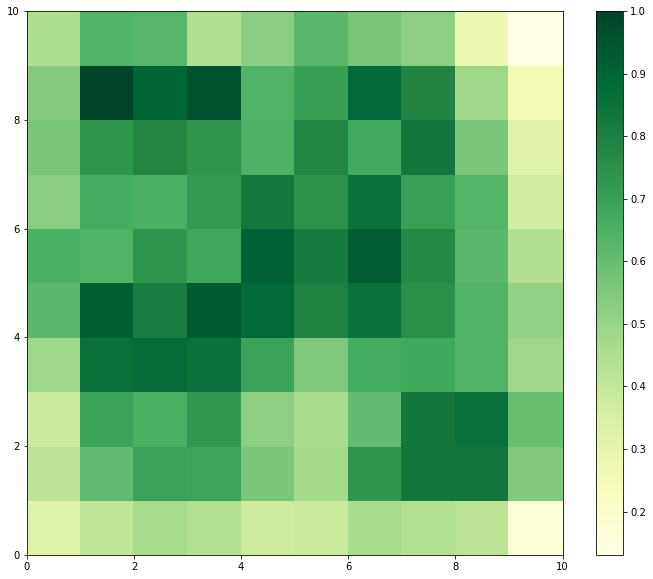

In [12]:
plt.figure(figsize=(12, 10))
bone()
pcolor(som.distance_map().T, cmap='YlGn')
colorbar()

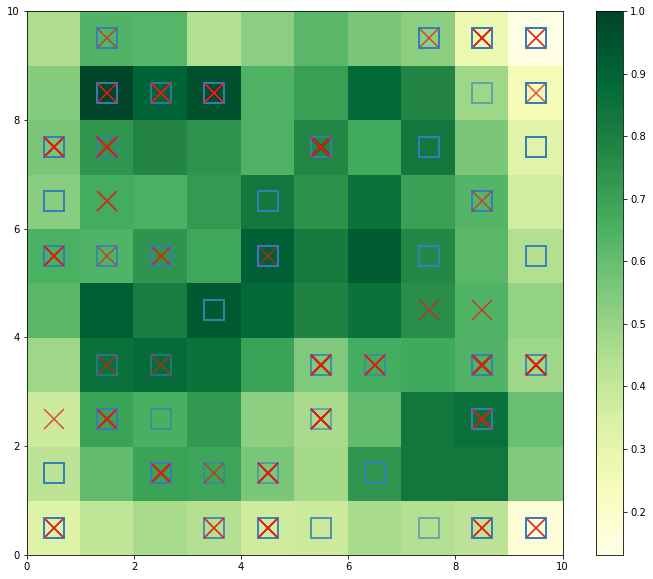

In [13]:
plt.figure(figsize=(12, 10))
bone()
pcolor(som.distance_map().T, cmap='YlGn')
colorbar()
markers = ['s', 'x']
colors = ['#377EB8', '#E41A1C']
for idx, vector in enumerate(X):
    winning_nodes = som.winner(vector)
    plot(winning_nodes[0] + 0.5, winning_nodes[1] + 0.5, markers[y[idx]], markeredgecolor=colors[y[idx]], markerfacecolor='None', markersize=20, markeredgewidth=1.5, alpha=0.75)

*Finding Frauds*

In [14]:
mappings = som.win_map(X)

In [15]:
frauds = np.concatenate((mappings[(1, 8)], mappings[(3, 8)], mappings[(4, 5)]), axis=0)

In [16]:
frauds = scaler.inverse_transform(frauds)

In [17]:
frauds[0]

array([1.5731586e+07, 0.0000000e+00, 2.9500000e+01, 2.0000000e+00,
       1.0000000e+00, 1.0000000e+01, 8.0000000e+00, 2.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       2.0000000e+00, 2.5600000e+02, 1.8000000e+01])

In [18]:
frauds.shape

(60, 15)

### Part 2 - Going from SOM (Unsupervised) to ANN (Supervised) to create hybrid ML model

*Creating Matrix of Feature*

In [19]:
customers = credit_df.drop('CustomerID', axis=1).values

*Creating the Dependent Variable*

In [20]:
is_fraud = np.zeros(len(credit_df))

In [21]:
for i in range(len(credit_df)):
    if credit_df['CustomerID'][i] in frauds:
        is_fraud[i] = 1

*Feature Scaling*

In [22]:
from sklearn.preprocessing import StandardScaler

In [23]:
std_scaler = StandardScaler()

In [24]:
customers = std_scaler.fit_transform(customers)

*Building and fitting the ANN*

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
ann = Sequential()

In [27]:
# Hidden Layers
ann.add(Dense(units=15, activation='relu'))
ann.add(Dense(units=8, activation='relu'))

# Output Layer
ann.add(Dense(1, activation='sigmoid'))

#Compiling ANN
ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [28]:
early_stop = EarlyStopping(monitor='accuracy', mode='max', patience=10)

In [29]:
ann.fit(customers, is_fraud, batch_size=8, epochs=100, callbacks=[early_stop])

Train on 690 samples
Epoch 1/100
690/690 [==============================] - 1s 2ms/sample - loss: 0.4427 - accuracy: 0.8464
Epoch 2/100
690/690 [==============================] - 0s 347us/sample - loss: 0.2683 - accuracy: 0.9130
Epoch 3/100
690/690 [==============================] - 0s 354us/sample - loss: 0.2156 - accuracy: 0.9145
Epoch 4/100
690/690 [==============================] - 0s 325us/sample - loss: 0.1832 - accuracy: 0.9188
Epoch 5/100
690/690 [==============================] - 0s 341us/sample - loss: 0.1584 - accuracy: 0.9290
Epoch 6/100
690/690 [==============================] - 0s 361us/sample - loss: 0.1381 - accuracy: 0.9420
Epoch 7/100
690/690 [==============================] - 0s 321us/sample - loss: 0.1202 - accuracy: 0.9507
Epoch 8/100
690/690 [==============================] - 0s 356us/sample - loss: 0.1066 - accuracy: 0.9594
Epoch 9/100
690/690 [==============================] - 0s 387us/sample - loss: 0.0955 - accuracy: 0.9638
Epoch 10/100
690/690 [==============

*Visualizing the epoch Accuracy and Loss*

In [30]:
loss_df = pd.DataFrame(ann.history.history)

In [31]:
loss_df.head()

,loss,accuracy
0,0.442737,0.846377
1,0.268263,0.913043
2,0.215628,0.914493
3,0.183204,0.918841
4,0.158426,0.928986


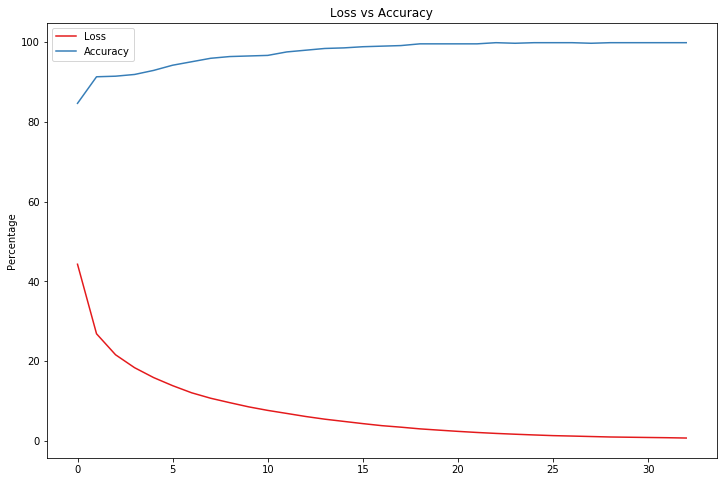

In [32]:
plt.figure(figsize=(12, 8))
sns.lineplot(x=loss_df.index, y=loss_df['loss'] * 100, label='Loss', color='#E41A1C')
sns.lineplot(x=loss_df.index, y=loss_df['accuracy'] * 100, label='Accuracy', color='#377EB8').set(ylabel='Percentage', title='Loss vs Accuracy')
plt.legend()

*Making Prediction*

In [33]:
pred = ann.predict(customers)

*Rank Probalities*

In [34]:
y_pred = pd.DataFrame()
y_pred['CustomerID'] = credit_df['CustomerID']
y_pred['Fraud Probablity'] = pred

In [35]:
ranked_pred = y_pred.sort_values('Fraud Probablity', ascending=False)